In [24]:
#Importing Pandas library for data upload and analysis
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandoc

#Import datafile, downloaded from World Bank Development Indicators
income_data = pd.read_excel("Adjusted National Income and Population.xlsx")

In [2]:
#Data Exploration 

print(income_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   188 non-null    object
 1   Country Code   186 non-null    object
 2   Series Name    186 non-null    object
 3   Series Code    186 non-null    object
 4   2001 [YR2001]  186 non-null    object
 5   2002 [YR2002]  186 non-null    object
 6   2003 [YR2003]  186 non-null    object
 7   2004 [YR2004]  186 non-null    object
 8   2005 [YR2005]  186 non-null    object
 9   2006 [YR2006]  186 non-null    object
 10  2007 [YR2007]  186 non-null    object
 11  2008 [YR2008]  186 non-null    object
 12  2009 [YR2009]  186 non-null    object
 13  2010 [YR2010]  186 non-null    object
 14  2011 [YR2011]  186 non-null    object
 15  2012 [YR2012]  186 non-null    object
 16  2013 [YR2013]  186 non-null    object
 17  2014 [YR2014]  186 non-null    object
 18  2015 [YR2015]  186 non-null   

The data exploration reveals the data is clean but could use some improvements. Year names should be reduced to a single integer. All datatypes are objects and may need to be converted pending data analysis strategies. Missing entries (entriess filed as "...") should be removed. For ease of understanding, we were convert the dataset to a Dataframe, and we will use the style function to view it in a tabular format. 

In [3]:
#The function remove brackets, applied to the income_data dataset to remove the bracketed year ending.

def remove_brackets(column_name):
    if column_name.endswith(']'):
        column_name = column_name[:-9]
    else:
        pass
    return column_name
income_data = income_data.rename(columns=remove_brackets)

#Now, we remove all "..." values. These show no data, and we only want countries which offer both data in all years.
#We are also dropped the series code section because it
#is not important to our analysis.
income_data = income_data.drop('Series Code', axis=1)

#Remove all missing entries, which in this case are "..."
income_data = income_data.replace("..", np.NaN).dropna()

#Removing missing values leaves some countries which only have sufficient data for income.
#We want only countries with both, so this removes any non-duplicate entries. 
income_data = income_data[income_data.duplicated(subset=['Country Name'], keep=False)]

#Convert all data from object type to string type. Names of countries and series will be left as is. 
income_data = income_data.convert_dtypes()

# Convert columns 3 through 21 to numeric and then to integer
income_data.iloc[:, 3:22] = income_data.iloc[:, 3:22].apply(pd.to_numeric, errors='coerce').astype('Int64')

income_data.info()

#Select only the year columns, and pull the log10 of each number. This adjusts the scale to allow for 
#ease of data visualization. 
#income_data.iloc[:, 3:22] = income_data.iloc[:, 3:22].apply(lambda x: np.log10(x))

income_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 185
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  148 non-null    string 
 1   Country Code  148 non-null    string 
 2   Series Name   148 non-null    string 
 3   2001          148 non-null    Int64  
 4   2002          148 non-null    Int64  
 5   2003          148 non-null    Int64  
 6   2004          148 non-null    Int64  
 7   2005          148 non-null    Int64  
 8   2006          148 non-null    Int64  
 9   2007          148 non-null    Int64  
 10  2008          148 non-null    Int64  
 11  2009          148 non-null    Int64  
 12  2010          148 non-null    Int64  
 13  2011          148 non-null    Int64  
 14  2012          148 non-null    Int64  
 15  2013          148 non-null    Int64  
 16  2014          148 non-null    Int64  
 17  2015          148 non-null    Int64  
 18  2016          148 non-null    

C:\Users\Magaret\AppData\Local\Temp\ipykernel_22904\1080657241.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  income_data.iloc[:, 3:22] = income_data.iloc[:, 3:22].apply(pd.to_numeric, errors='coerce').astype('Int64')


,Country Name,Country Code,Series Name,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Angola,AGO,"Population, total",16941587,17516139,18124342,18771125,19450959,20162340,20909684,...,25188292,26147002,27128337,28127721,29154746,30208628,31273533,32353588,33428486.0,34503774.0
1,Angola,AGO,Adjusted net national income (current US$),4259081638,9587531694,11841538648,14498522980,19664495927,27561990009,30719156009,...,72141626387,83346229610,94702895519,66790173500,35196052952,45362409567,47156217466,42988475833,36803520680.486298,42541367192.0476
4,Argentina,ARG,"Population, total",37480493,37885028,38278164,38668796,39070501,39476851,39876111,...,41733271,42202935,42669500,43131966,43590368,44044811,44494502,44938712,45376763.0,45808747.0
5,Argentina,ARG,Adjusted net national income (current US$),224968752618,75590438007,103448403705,124005526472,148938243056,193236491249,243687486346,...,454254301661,460395962371,438031034121,507308748132,473643779848,554002069337,439587197173,370477828048,327236387986.867004,411983137959.539978
6,Aruba,ABW,"Population, total",90691,91781,92701,93540,94483,95606,96787,...,102112,102880,103594,104257,104874,105439,105962,106442,106585.0,106537.0


In [4]:
income_data['2001'].describe()

count                  148.0
mean      78686448627.972977
std      750024936640.292236
min                  68153.0
25%                7118496.0
50%              212189794.5
75%            4138865384.25
max          9087323150609.0
Name: 2001, dtype: Float64

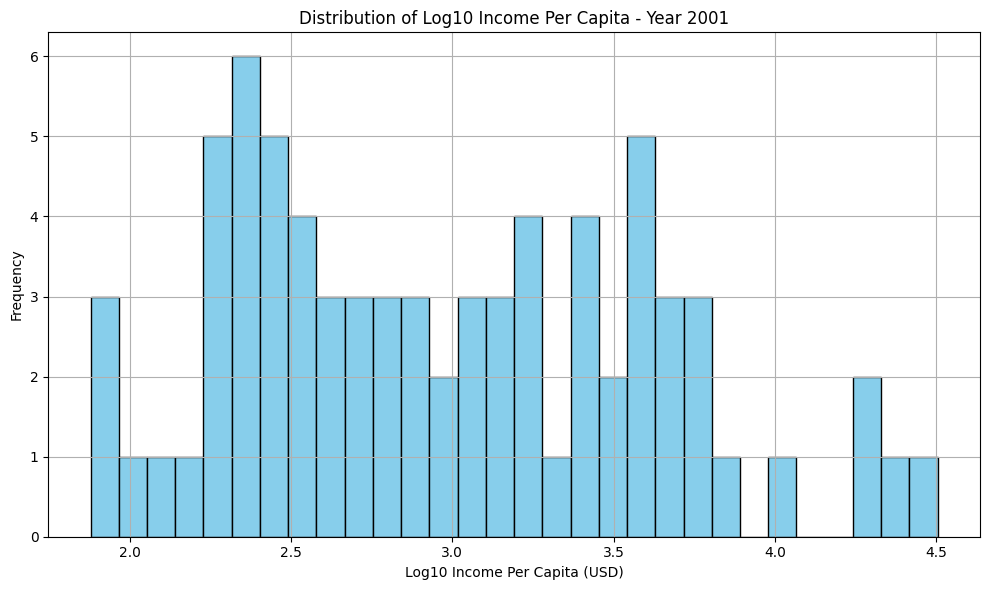

In [5]:
##Graph for the Year 2001
#Building dataframes of only the population and income data to work with 
population_data = income_data[income_data['Series Name'] == 'Population, total'][['Country Name', '2001']]
net_income = income_data[income_data['Series Name'] == 'Adjusted net national income (current US$)'][['Country Name', '2001']]

# Filter the DataFrame for the year 2001
population_data_2001 = population_data[['Country Name', '2001']]
net_income_2001 = net_income[['Country Name', '2001']]

# Merge the population and income DataFrames for the year 2001
merged_data_2001 = pd.merge(population_data_2001, net_income_2001, on=['Country Name'])

# Compute the log10 of income per capita for the year 2001
merged_data_2001['Population'] = (merged_data_2001['2001_x'])
merged_data_2001['Log10 Income Per Capita'] = np.log10(merged_data_2001['2001_y'] / merged_data_2001['2001_x'])

# Plotting a histogram for the year 2001 with styling
plt.figure(figsize=(10, 6))
plt.hist(merged_data_2001['Log10 Income Per Capita'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Log10 Income Per Capita (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Log10 Income Per Capita - Year 2001')
plt.grid(True)
plt.tight_layout()  # Improving layout
plt.show()


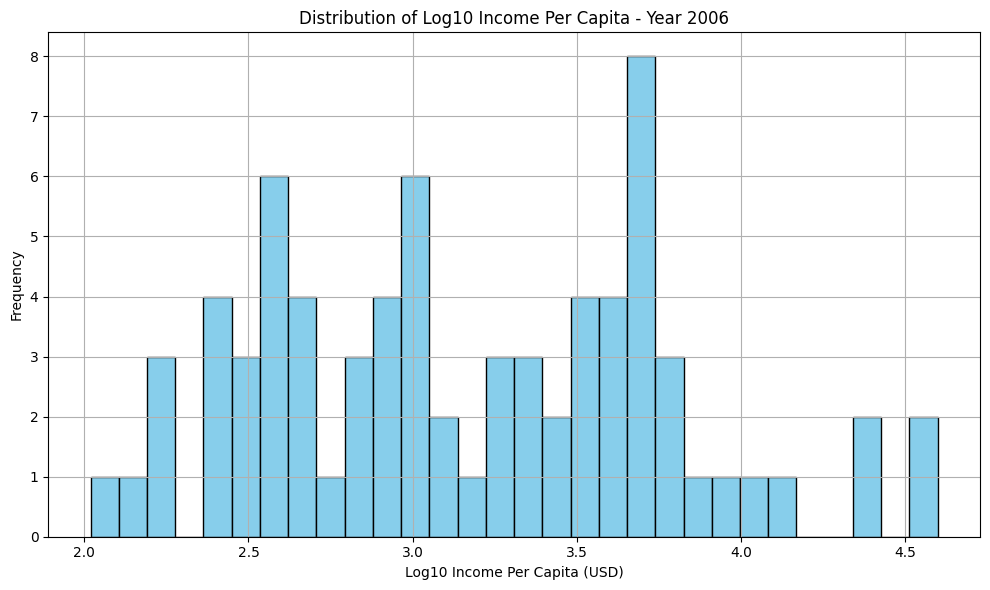

In [6]:
##Graph for the Year 2006
#Building dataframes of only the population and income data to work with 
population_data = income_data[income_data['Series Name'] == 'Population, total'][['Country Name', '2006']]
net_income = income_data[income_data['Series Name'] == 'Adjusted net national income (current US$)'][['Country Name', '2006']]

# Filter the DataFrame for the year 2006
population_data_2006 = population_data[['Country Name', '2006']]
net_income_2006 = net_income[['Country Name', '2006']]

# Merge the population and income DataFrames for the year 2006
merged_data_2006 = pd.merge(population_data_2006, net_income_2006, on=['Country Name'])

# Compute the log10 of income per capita for the year 2006
merged_data_2006['Population'] = (merged_data_2006['2006_x'])
merged_data_2006['Log10 Income Per Capita'] = np.log10(merged_data_2006['2006_y'] / merged_data_2006['2006_x'])

# Plotting a histogram for the year 2006 with styling
plt.figure(figsize=(10, 6))
plt.hist(merged_data_2006['Log10 Income Per Capita'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Log10 Income Per Capita (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Log10 Income Per Capita - Year 2006')
plt.grid(True)
plt.tight_layout()  # Improving layout
plt.show()


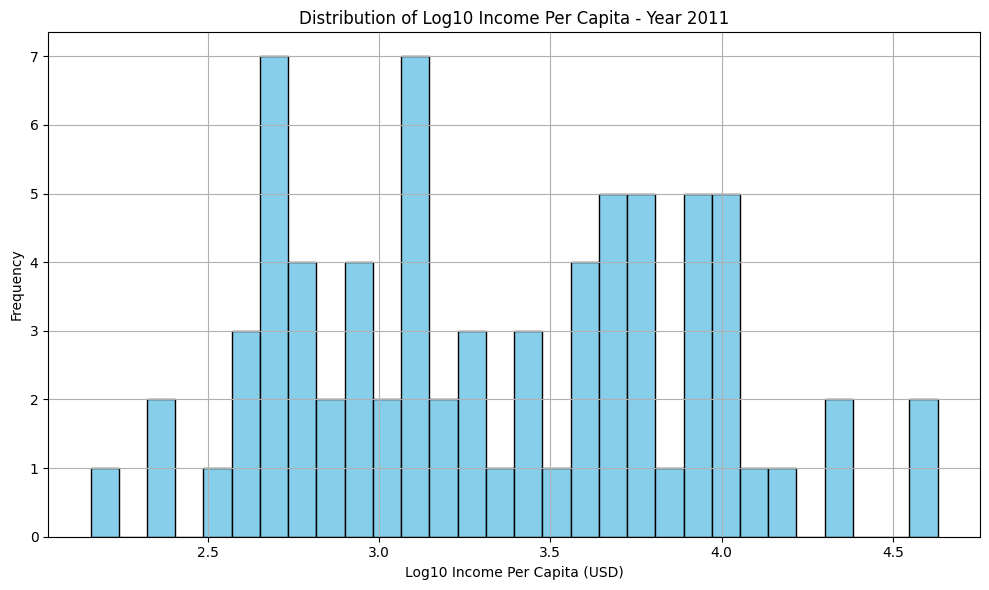

In [7]:
##Graph for the Year 2011
#Building dataframes of only the population and income data to work with 
population_data = income_data[income_data['Series Name'] == 'Population, total'][['Country Name', '2011']]
net_income = income_data[income_data['Series Name'] == 'Adjusted net national income (current US$)'][['Country Name', '2011']]

# Filter the DataFrame for the year 2011
population_data_2011 = population_data[['Country Name', '2011']]
net_income_2011 = net_income[['Country Name', '2011']]

# Merge the population and income DataFrames for the year 2011
merged_data_2011 = pd.merge(population_data_2011, net_income_2011, on=['Country Name'])

# Compute the log10 of income per capita for the year 2011
merged_data_2011['Population'] = (merged_data_2011['2011_x'])
merged_data_2011['Log10 Income Per Capita'] = np.log10(merged_data_2011['2011_y'] / merged_data_2011['2011_x'])

# Plotting a histogram for the year 2011 with styling
plt.figure(figsize=(10, 6))
plt.hist(merged_data_2011['Log10 Income Per Capita'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Log10 Income Per Capita (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Log10 Income Per Capita - Year 2011')
plt.grid(True)
plt.tight_layout()  # Improving layout
plt.show()


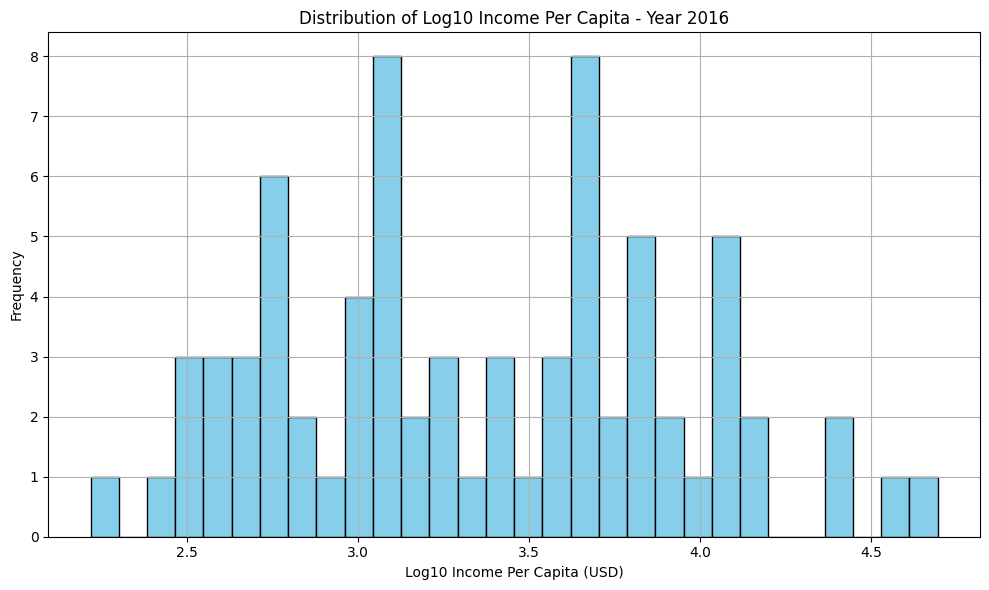

In [8]:
##Graph for the Year 2016
#Building dataframes of only the population and income data to work with 
population_data = income_data[income_data['Series Name'] == 'Population, total'][['Country Name', '2016']]
net_income = income_data[income_data['Series Name'] == 'Adjusted net national income (current US$)'][['Country Name', '2016']]

# Filter the DataFrame for the year 2016
population_data_2016 = population_data[['Country Name', '2016']]
net_income_2016 = net_income[['Country Name', '2016']]

# Merge the population and income DataFrames for the year 2016
merged_data_2016 = pd.merge(population_data_2016, net_income_2016, on=['Country Name'])

# Compute the log10 of income per capita for the year 2016
merged_data_2016['Population'] = (merged_data_2016['2016_x'])
merged_data_2016['Log10 Income Per Capita'] = np.log10(merged_data_2016['2016_y'] / merged_data_2016['2016_x'])

# Plotting a histogram for the year 2016 with styling
plt.figure(figsize=(10, 6))
plt.hist(merged_data_2016['Log10 Income Per Capita'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Log10 Income Per Capita (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Log10 Income Per Capita - Year 2016')
plt.grid(True)
plt.tight_layout()  # Improving layout
plt.show()


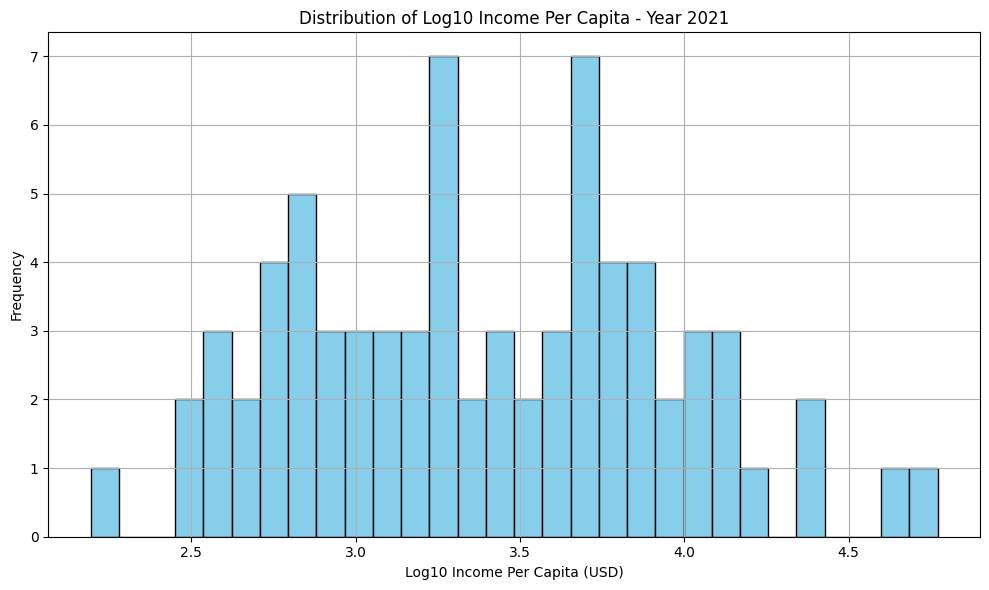

In [9]:
##Graph for the Year 2021

#Building dataframes of only the population and income data to work with 
population_data = income_data[income_data['Series Name'] == 'Population, total'][['Country Name', '2021']]
net_income = income_data[income_data['Series Name'] == 'Adjusted net national income (current US$)'][['Country Name', '2021']]

# Filter the DataFrame for the year 2021
population_data_2021 = population_data[['Country Name', '2021']]
net_income_2021 = net_income[['Country Name', '2021']]

# Merge the population and income DataFrames for the year 2021
merged_data_2021 = pd.merge(population_data_2021, net_income_2021, on=['Country Name'])

# Compute the log10 of income per capita for the year 2021
merged_data_2021['Population'] = (merged_data_2021['2021_x'])
merged_data_2021['Log10 Income Per Capita'] = np.log10(merged_data_2021['2021_y'] / merged_data_2021['2021_x'])

# Plotting a histogram for the year 2021 with styling
plt.figure(figsize=(10, 6))
plt.hist(merged_data_2021['Log10 Income Per Capita'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Log10 Income Per Capita (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Log10 Income Per Capita - Year 2021')
plt.grid(True)
plt.tight_layout()  # Improving layout
plt.show()


Below, I determine different peaks using the SciPy find_peaks tool. The peak value identifies the prevalence of the peak.  Clear troughs in the histograms for every year mark the perimeter of the core (PC) and perimeter of the periphery (PP). I select the peaks (the most frequent values) at core, semi-periphery, and periphery ranges, reflecting the peaks identified by the histograms above. I convert the income per capitas back from their log10 normalization. These show the divisions in my world-systems analysis. I first perform the income peaks indentification for 2001, then repeat the process for 2021 in order to analyze for change over time.

Peak Value: 6, Bin Center: 2.3600204213054563
Peak Value: 4, Bin Center: 3.2349665441550113
Peak Value: 4, Bin Center: 3.409955768724922
Peak Value: 5, Bin Center: 3.584944993294833
Peak Value: 1, Bin Center: 4.02241805471961
Peak Value: 2, Bin Center: 4.284901891574478
Trough Value: 1, Bin Center: 2.0975365844505895
Trough Value: 2, Bin Center: 2.9724827073001445
Trough Value: 1, Bin Center: 3.322461156439967
Trough Value: 2, Bin Center: 3.4974503810098776
Trough Value: 0, Bin Center: 3.934923442434655
Trough Value: 0, Bin Center: 4.109912667004567


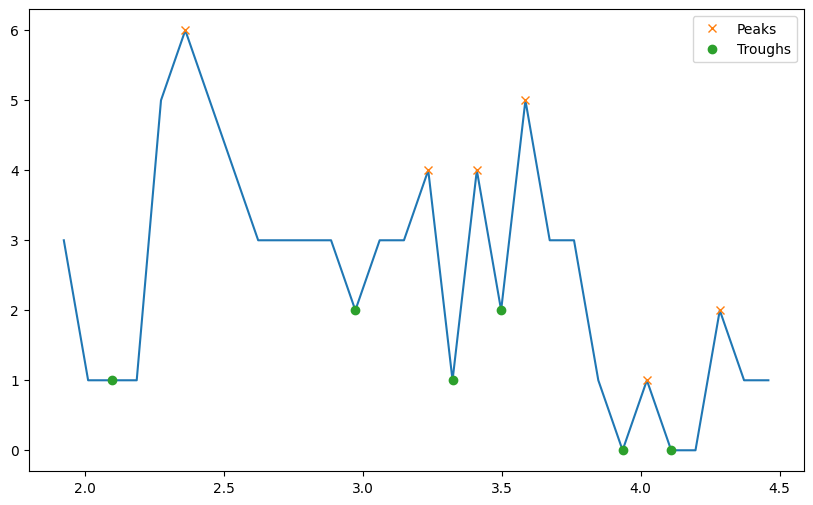

In [10]:
data = merged_data_2001['Log10 Income Per Capita']

# Create a histogram
hist, bin_edges = np.histogram(data, 30)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, hist)

# Find peaks and troughs in the histogram
peaks, _ = find_peaks(hist, prominence=0.1)  # Adjust prominence threshold as needed
troughs, _ = find_peaks(-hist, prominence=0.1)  # Use negative histogram for troughs

# Plot the peaks and troughs on the histogram
plt.plot(bin_centers[peaks], hist[peaks], "x", label="Peaks")
plt.plot(bin_centers[troughs], hist[troughs], "o", label="Troughs")

# Get the values of the peaks and troughs
peak_values = hist[peaks]
peak_bin_centers = bin_centers[peaks]
trough_values = hist[troughs]
trough_bin_centers = bin_centers[troughs]

# Print the peak values and their corresponding bin centers
for value, center in zip(peak_values, peak_bin_centers):
    print(f"Peak Value: {value}, Bin Center: {center}")

# Print the trough values and their corresponding bin centers
for value, center in zip(trough_values, trough_bin_centers):
    print(f"Trough Value: {value}, Bin Center: {center}")

# Show the plot
plt.legend()
plt.show()


In [11]:
# Undo the log10 operation to see the income per capita for 2001
perimeter_of_p_2001 = 10 ** 2.9724827073001445
perimeter_of_c_2001 = 10 ** 3.934923442434655

print(perimeter_of_p_2001, perimeter_of_c_2001)  # This will print the income per capitas of the periphery, the semi-perihpery, and the core.

#Defined by Babones as 1059 and 8414

938.6046626493529 8608.41989316956


Peak Value: 3, Bin Center: 2.579591249314911
Peak Value: 5, Bin Center: 2.8373948202658674
Peak Value: 7, Bin Center: 3.2670674385174614
Peak Value: 3, Bin Center: 3.438936485818099
Peak Value: 7, Bin Center: 3.696740056769055
Peak Value: 3, Bin Center: 4.04047815137033
Peak Value: 2, Bin Center: 4.384216245971605
Trough Value: 0, Bin Center: 2.321787678363955
Trough Value: 2, Bin Center: 2.66552577296523
Trough Value: 3, Bin Center: 3.009263867566505
Trough Value: 2, Bin Center: 3.35300196216778
Trough Value: 2, Bin Center: 3.5248710094684177
Trough Value: 2, Bin Center: 3.9545436277200112
Trough Value: 0, Bin Center: 4.298281722321287
Trough Value: 0, Bin Center: 4.470150769621924


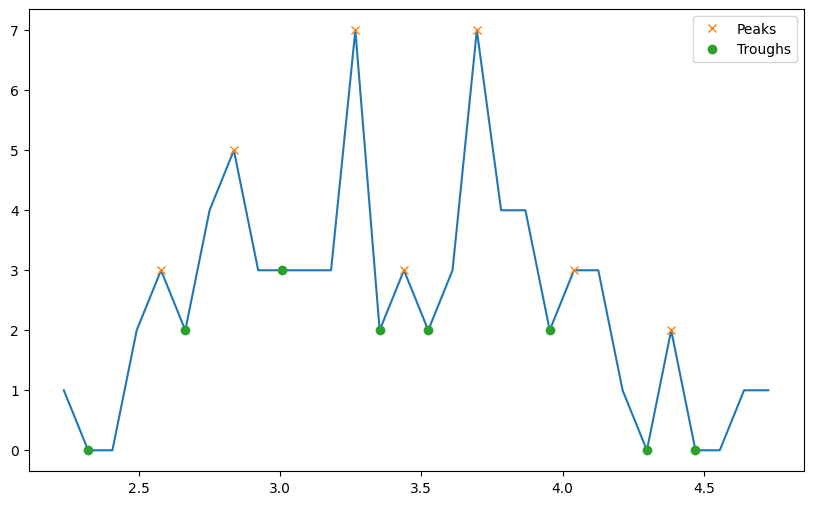

In [12]:
data = merged_data_2021['Log10 Income Per Capita']

# Create a histogram
hist, bin_edges = np.histogram(data, 30)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, hist)

# Find peaks and troughs in the histogram
peaks, _ = find_peaks(hist, prominence=0.1)  # Adjust prominence threshold as needed
troughs, _ = find_peaks(-hist, prominence=0.1)  # Use negative histogram for troughs

# Plot the peaks and troughs on the histogram
plt.plot(bin_centers[peaks], hist[peaks], "x", label="Peaks")
plt.plot(bin_centers[troughs], hist[troughs], "o", label="Troughs")

# Get the values of the peaks and troughs
peak_values = hist[peaks]
peak_bin_centers = bin_centers[peaks]
trough_values = hist[troughs]
trough_bin_centers = bin_centers[troughs]

# Print the peak values and their corresponding bin centers
for value, center in zip(peak_values, peak_bin_centers):
    print(f"Peak Value: {value}, Bin Center: {center}")

# Print the trough values and their corresponding bin centers
for value, center in zip(trough_values, trough_bin_centers):
    print(f"Trough Value: {value}, Bin Center: {center}")

# Show the plot
plt.legend()
plt.show()


In [13]:
# Undo the log10 operation to see the income per capita for 2021
perimeter_of_p_2021 = 10 ** 3.5248710094684177 #3348.659652848052
perimeter_of_c_2021 = 10 ** 4.470150769621924 #31622.776601683792
print(perimeter_of_p_2021, perimeter_of_c_2021)  # This will print the income per capitas of the periphery, the semi-perihpery, and the core.


3348.659652848052 29522.339459793606


Now, I want to develop a scatterplot with the World-Systems divisions of countries compared to their adoption of the right to food. This requires pulling an income per capita dataset from my original income data dataframe by calulcating the income of a country divided by its population. Then, I can classify their income per capita into periphery, semi-periphery, and core based on my determined thresholds above, and then plot that data on an axis against the adoption of the right to food. 

In [14]:
# Filter the DataFrame for 'Adjusted net national income (current US$)' and 'Population, total'
income_data_filtered = income_data[(income_data['Series Name'] == 'Adjusted net national income (current US$)') | (income_data['Series Name'] == 'Population, total')]

# Pivot the filtered DataFrame to have 'Country Name' as columns
income_data_pivoted = income_data_filtered.pivot(index='Country Name', columns='Series Name')

# Convert columns to numeric data type
income_data_pivoted = income_data_pivoted.apply(pd.to_numeric, errors='coerce')

# Calculate income per capita for the year 2001
income_per_capita_2001 = income_data_pivoted[('2001', 'Adjusted net national income (current US$)')] / income_data_pivoted[('2001', 'Population, total')]

# Create a new DataFrame with 'Country Name' and 'Income Per Capita 2001' columns
income_per_capita_df_2001 = pd.DataFrame({
    'Country Name': income_per_capita_2001.index,
    'Income Per Capita 2001': income_per_capita_2001.values
})

# Display the new DataFrame
income_per_capita_df_2001.head(20)

,Country Name,Income Per Capita 2001
0,Angola,251.398032
1,Argentina,6002.289047
2,Aruba,18128.182466
3,"Bahamas, The",23003.520429
4,Barbados,9986.699511
5,Belize,3720.643531
6,Benin,422.044005
7,Bolivia,807.258324
8,Botswana,2693.915347
9,Brazil,2553.031275


In [15]:
# Define a function to categorize income per capita values
def code_income(value):
    if value <= perimeter_of_p_2001:
        return 1
    elif perimeter_of_p_2001 < value < perimeter_of_c_2001:
        return 2
    else:
        return 3

# Replace non-finite values with -1
income_per_capita_df_2001['Income Per Capita 2001'] = income_per_capita_df_2001['Income Per Capita 2001'].replace([np.nan, np.inf, -np.inf], -1)

# Apply the function to create the coded column and remove decimals
income_per_capita_df_2001['Income Code'] = income_per_capita_df_2001['Income Per Capita 2001'].apply(code_income).astype(int)

# Select only the necessary columns
coded_income_df_2001 = income_per_capita_df_2001[['Country Name', 'Income Code']]

# Display the new DataFrame
coded_income_df_2001.head(60)

,Country Name,Income Code
0,Angola,1
1,Argentina,2
2,Aruba,3
3,"Bahamas, The",3
4,Barbados,3
5,Belize,2
6,Benin,1
7,Bolivia,1
8,Botswana,2
9,Brazil,2


In [16]:
#Now for 2021! The income per capita

# Filter the DataFrame for 'Adjusted net national income (current US$)' and 'Population, total'
income_data_filtered = income_data[(income_data['Series Name'] == 'Adjusted net national income (current US$)') | (income_data['Series Name'] == 'Population, total')]

# Pivot the filtered DataFrame to have 'Country Name' as columns
income_data_pivoted = income_data_filtered.pivot(index='Country Name', columns='Series Name')

# Convert columns to numeric data type
income_data_pivoted = income_data_pivoted.apply(pd.to_numeric, errors='coerce')

# Calculate income per capita for the year 2021
income_per_capita_2021 = income_data_pivoted[('2021', 'Adjusted net national income (current US$)')] / income_data_pivoted[('2021', 'Population, total')]

# Create a new DataFrame with 'Country Name' and 'Income Per Capita 2021' columns
income_per_capita_df_2021 = pd.DataFrame({
    'Country Name': income_per_capita_2021.index,
    'Income Per Capita 2021': income_per_capita_2021.values
})

# Display the new DataFrame
income_per_capita_df_2021.head(50)

,Country Name,Income Per Capita 2021
0,Angola,1232.948233
1,Argentina,8993.54741
2,Aruba,24994.772988
3,"Bahamas, The",24192.527809
4,Barbados,14810.010949
5,Belize,4823.481794
6,Benin,1210.886887
7,Bolivia,2625.319925
8,Botswana,5061.469177
9,Brazil,5647.133915


In [17]:
# Define a function to categorize income per capita values
def code_income(value):
    if value <= perimeter_of_p_2021:
        return 1
    elif perimeter_of_p_2021 < value < perimeter_of_c_2021:
        return 2
    else:
        return 3

# Replace non-finite values with -1
income_per_capita_df_2021['Income Per Capita 2021'] = income_per_capita_df_2021['Income Per Capita 2021'].replace([np.nan, np.inf, -np.inf], -1)

# Apply the function to create the coded column and remove decimals
income_per_capita_df_2021['Income Code 2021'] = income_per_capita_df_2021['Income Per Capita 2021'].apply(code_income).astype(int)

# Select only the necessary columns
coded_income_df_2021 = income_per_capita_df_2021[['Country Name', 'Income Code 2021']]

# Display the new DataFrame
coded_income_df_2021.head(20)

,Country Name,Income Code 2021
0,Angola,1
1,Argentina,2
2,Aruba,2
3,"Bahamas, The",2
4,Barbados,2
5,Belize,2
6,Benin,1
7,Bolivia,1
8,Botswana,2
9,Brazil,2


To make the final scatterplot, the 2021 data will be used, as I will not be collecting data on the right to food policy adoption for the year 2001 as coding manually was a slow process. 2001 will only be used to compare world-systems placement changes; however, a further comparison of the different scatterplots could be interesting. Next, I will produce the dataframe of the adoption of the right to food, and combine it with the above coded income in the world-system, to then visualize. 

In [18]:
### Making the Dataframe to hold country thresholds in the category of adoption of the right to food.
#Country list of ratification was manually typed for 73 nations, according to OHCHR data.
#Level 0: No known right to food
#Level 1: Adopted in ratification  international treaties and/or ISECR. 
#Level 2: Adopted in constitution, explicitly or implicitly or within declaration of rights. 
#Level 3: Adopted in creation of framework law

names_countries = income_data['Country Name'].drop_duplicates()
adoption_level = [1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 3, 1, 3, 3, 1, 2, 1, 1, 2, 3, 2, 1, 2, 2, 3, 1, 2, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 2, 2, 3, 3,1,1, 1, 1, 2,3, 1,1, 2, 3, 1, 1, 3, 0, 1, 1, 1]


# get the list of tuples from two lists.
# and merge them by using zip().
list_of_tuples = list(zip(names_countries, adoption_level ))
 
# Assign data to tuples.
list_of_tuples
 
 
# Converting lists of tuples into
# pandas Dataframe.
adoption_df = pd.DataFrame(list_of_tuples,
                  columns=['Country Name', 'Right to Food Adoption Benchmark'])
 
# Print the output.
adoption_df.style


,Country Name,Right to Food Adoption Benchmark
0,Angola,1
1,Argentina,3
2,Aruba,0
3,"Bahamas, The",1
4,Barbados,1
5,Belize,1
6,Benin,1
7,Bolivia,3
8,Botswana,0
9,Brazil,3


In [25]:
# Merge the two DataFrames on the "Country Name" column
final_df = adoption_df.merge(coded_income_df_2021, on='Country Name', how='left')

# Display the merged DataFrame
final_df.head(20)

,Country Name,Right to Food Adoption Benchmark,Income Code 2021
0,Angola,1,1
1,Argentina,3,2
2,Aruba,0,2
3,"Bahamas, The",1,2
4,Barbados,1,2
5,Belize,1,2
6,Benin,1,1
7,Bolivia,3,1
8,Botswana,0,2
9,Brazil,3,2


In [20]:
filtered_df = final_df[final_df['Income Code 2021'] == 1]

# Count the occurrences of values in the first column
count_values = filtered_df['Right to Food Adoption Benchmark'].value_counts()

# Calculate the total count of countries with Income Code 2021 as 1
total_count = len(filtered_df)

# Calculate the percentages
percentages = {}
for value, count in count_values.items():
    percentages[value] = (count / total_count) * 100

# Print the percentages
print("Percentages of Periphery Countries by Adoption Level")
print(f"Percent of periphery countries with no known right to food: {percentages.get(0, 0):.0f}%")
print(f"Percent of periphery countries having at most ratified multilateral treaties: {percentages.get(1, 0):.0f}%")
print(f"Percent of periphery countries having at most a constitutional mention: {percentages.get(2, 0):.0f}%")
print(f"Percent of periphery countries having a framework law: {percentages.get(3, 0):.0f}%")


Percentages of Periphery Countries by Adoption Level
Percent of periphery countries with no known right to food: 2%
Percent of periphery countries having at most ratified multilateral treaties: 57%
Percent of periphery countries having at most a constitutional mention: 24%
Percent of periphery countries having a framework law: 17%


In [21]:
filtered_df = final_df[final_df['Income Code 2021'] == 2]

# Count the occurrences of values in the first column
count_values = filtered_df['Right to Food Adoption Benchmark'].value_counts()

# Calculate the total count of countries with Income Code 2021 as 2
total_count = len(filtered_df)

# Calculate the percentages
percentages = {}
for value, count in count_values.items():
    percentages[value] = (count / total_count) * 100

# Print the percentages
print("Percentages of Semi-Periphery Countries by Adoption Level")
print(f"Percent of semi-periphery countries with no known right to food: {percentages.get(0, 0):.0f}%")
print(f"Percent of semi-periphery countries having at most ratified multilateral treaties: {percentages.get(1, 0):.0f}%")
print(f"Percent of semi-periphery countries having at most a constitutional mention: {percentages.get(2, 0):.0f}%")
print(f"Percent of semi-periphery countries having a framework law: {percentages.get(3, 0):.0f}%")


Percentages of Semi-Periphery Countries by Adoption Level
Percent of semi-periphery countries with no known right to food: 7%
Percent of semi-periphery countries having at most ratified multilateral treaties: 47%
Percent of semi-periphery countries having at most a constitutional mention: 13%
Percent of semi-periphery countries having a framework law: 33%


In [22]:
filtered_df = final_df[final_df['Income Code 2021'] == 3]

# Count the occurrences of values in the first column
count_values = filtered_df['Right to Food Adoption Benchmark'].value_counts()

# Calculate the total count of countries with Income Code 2021 as 2
total_count = len(filtered_df)

# Calculate the percentages
percentages = {}
for value, count in count_values.items():
    percentages[value] = (count / total_count) * 100

# Print the percentages
print("Percentages of Core Countries by Adoption Level")
print(f"Percent of core countries with no known right to food: {percentages.get(0, 0):.0f}%")
print(f"Percent of core countries having at most ratified multilateral treaties: {percentages.get(1, 0):.0f}%")
print(f"Percent of core countries having at most a constitutional mention: {percentages.get(2, 0):.0f}%")
print(f"Percent of core countries having a framework law: {percentages.get(3, 0):.0f}%")


Percentages of Core Countries by Adoption Level
Percent of core countries with no known right to food: 50%
Percent of core countries having at most ratified multilateral treaties: 50%
Percent of core countries having at most a constitutional mention: 0%
Percent of core countries having a framework law: 0%


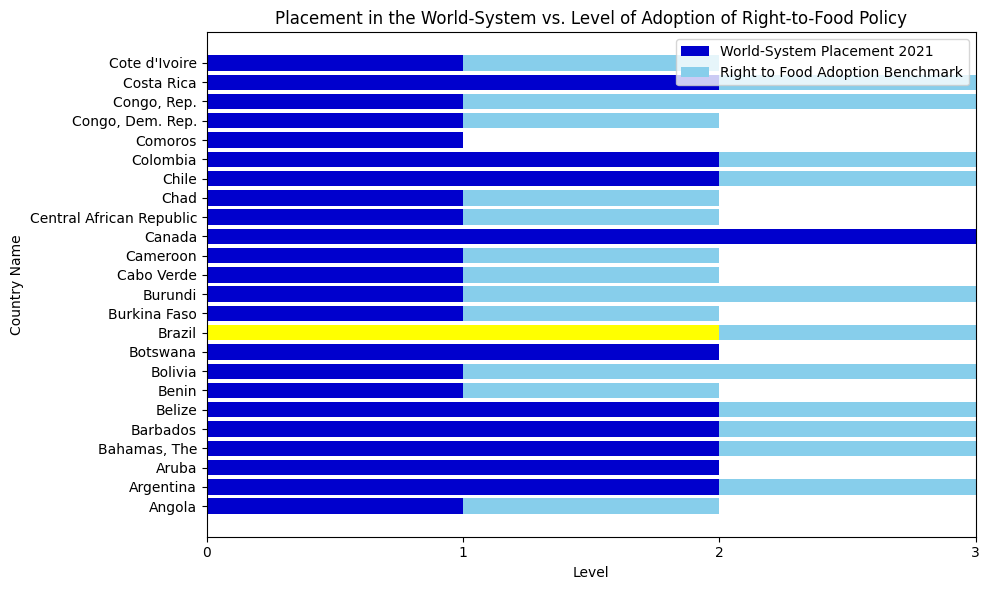

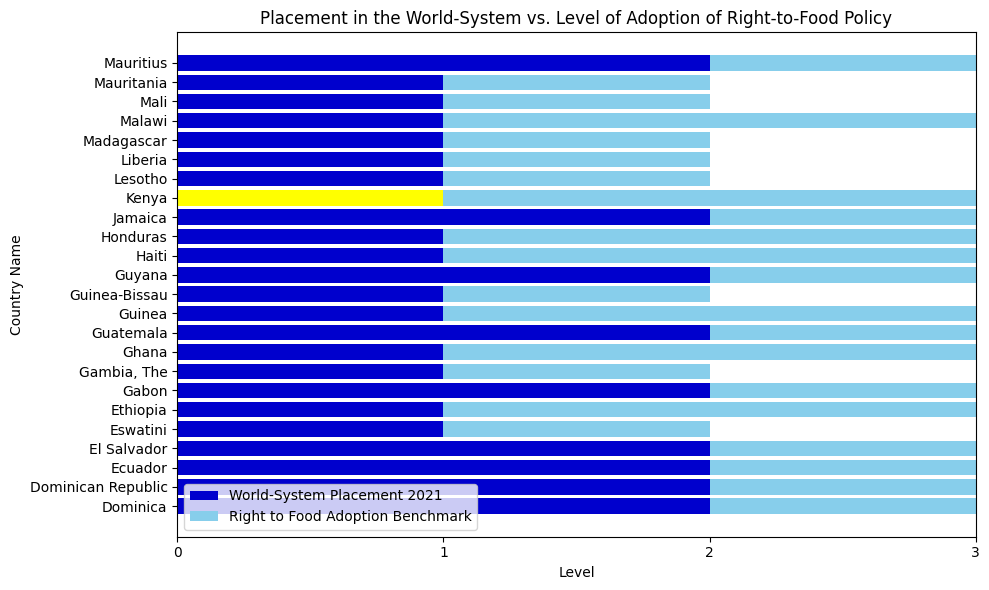

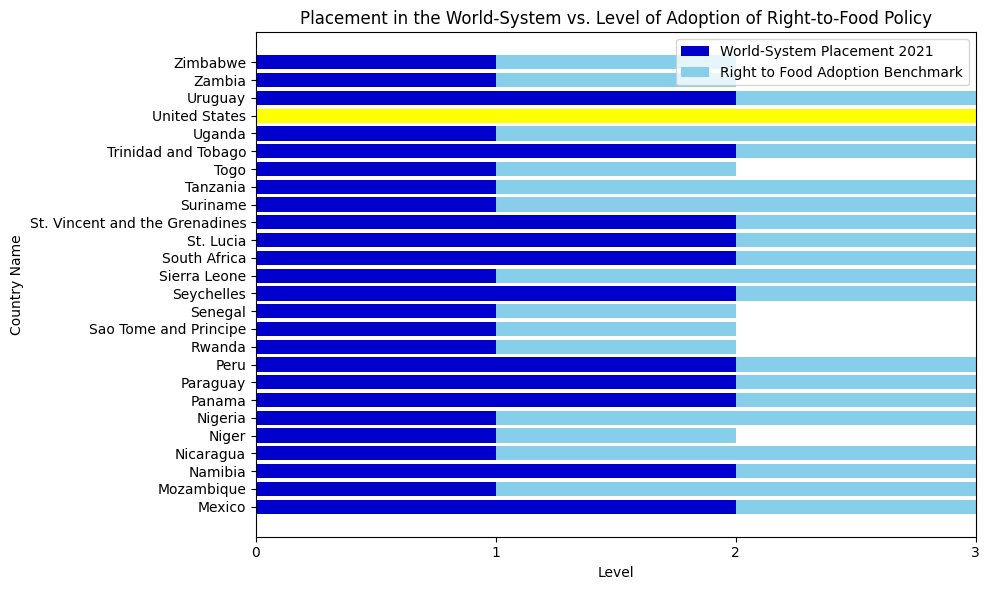

In [23]:
import matplotlib.pyplot as plt

# Split the final_df into three parts for legibility of charts
num_countries = len(final_df)
first_third = final_df.iloc[:num_countries // 3]
second_third = final_df.iloc[num_countries // 3: 2 * (num_countries // 3)]
third_third = final_df.iloc[2 * (num_countries // 3):]

# Function to create a horizontal bar graph for a given dataframe
def plot_horizontal_bar(df, title, highlight_countries=None):
    countries = df['Country Name']
    income_code = df['Income Code 2021']
    right_to_food = df['Right to Food Adoption Benchmark']

    plt.figure(figsize=(10, 6))
    
    # Highlight case countries in yellow
    colors = ['yellow' if country in highlight_countries else 'mediumblue' for country in countries]

    plt.barh(countries, income_code, color=colors, label='World-System Placement 2021')
    plt.barh(countries, right_to_food, color='skyblue', left=income_code, label='Right to Food Adoption Benchmark')
    plt.xlabel('Level')
    plt.ylabel('Country Name')
    plt.title(title)
    plt.xlim(0, 3)
    plt.xticks(range(max(max(income_code), max(right_to_food)) + 1))
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Case countries to highlight in yellow
highlight_countries = ['Brazil', 'Kenya', 'United States']

# Plotting the first third of the data with highlighted countries
plot_horizontal_bar(first_third, 'Placement in the World-System vs. Level of Adoption of Right-to-Food Policy', highlight_countries)

# Plotting the second third of the data with highlighted countries
plot_horizontal_bar(second_third, 'Placement in the World-System vs. Level of Adoption of Right-to-Food Policy', highlight_countries)

# Plotting the third third of the data with highlighted countries
plot_horizontal_bar(third_third, 'Placement in the World-System vs. Level of Adoption of Right-to-Food Policy', highlight_countries)
